# lenet model using openvino optimisation

## importing the required libraries

In [13]:
import torch
import torchvision.datasets as ds
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as tr
import torchvision.models as md
import  torch.optim as optim
from torch.utils.data import random_split
import numpy 
from torchvision import transforms
from PIL import Image

## downloading the data

In [14]:

fashion_mnist = ds.FashionMNIST(download=False, train=True, root="fashion_mnist_data").train_data.float()
data_transform = transforms.Compose([ transforms.Resize((28, 28)),                                    
                                         transforms.ToTensor(),
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

trainset = ds.FashionMNIST(root='fashion_mnist_data',
                                      train=True,
                                      download=True,
                                      transform=data_transform,
                          )

valset =  ds.FashionMNIST(root='fashion_mnist_data',
                                      train=True,
                                      download=True,
                                      transform=data_transform,
                          )

testset = ds.FashionMNIST(root='fashion_mnist_data',
                                     train=False,
                                     download=True,
                                     transform=data_transform
                                    )

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## split the training data into training, validation and tresting sets

In [15]:
train_set, val_set= torch.utils.data.random_split(trainset, [50000, 10000]) #splitting the dat


## visualizing an image in the given data

label:  0
torch.Size([1, 28, 28])


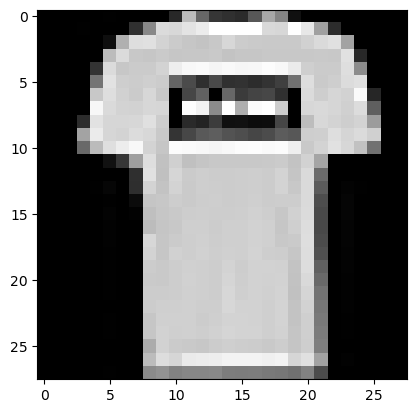

In [16]:
import matplotlib.pyplot as plt
# plot images
image , label = trainset[1]
labels = str(label)
plt.imshow(image.reshape(28,28), cmap = 'gray')
print('label: ',label)
print(image.shape)

## loading the data using dataloader with batchsize as 128

In [17]:
batchsize=128

traindlr = DataLoader(train_set,batchsize,shuffle =True) #for train set
valdlr = DataLoader(val_set,batchsize,shuffle =False) # for val set
testdlr = DataLoader(testset,batchsize,shuffle =False) # for test set

## displaying the first 36 images in the train set along with its labels

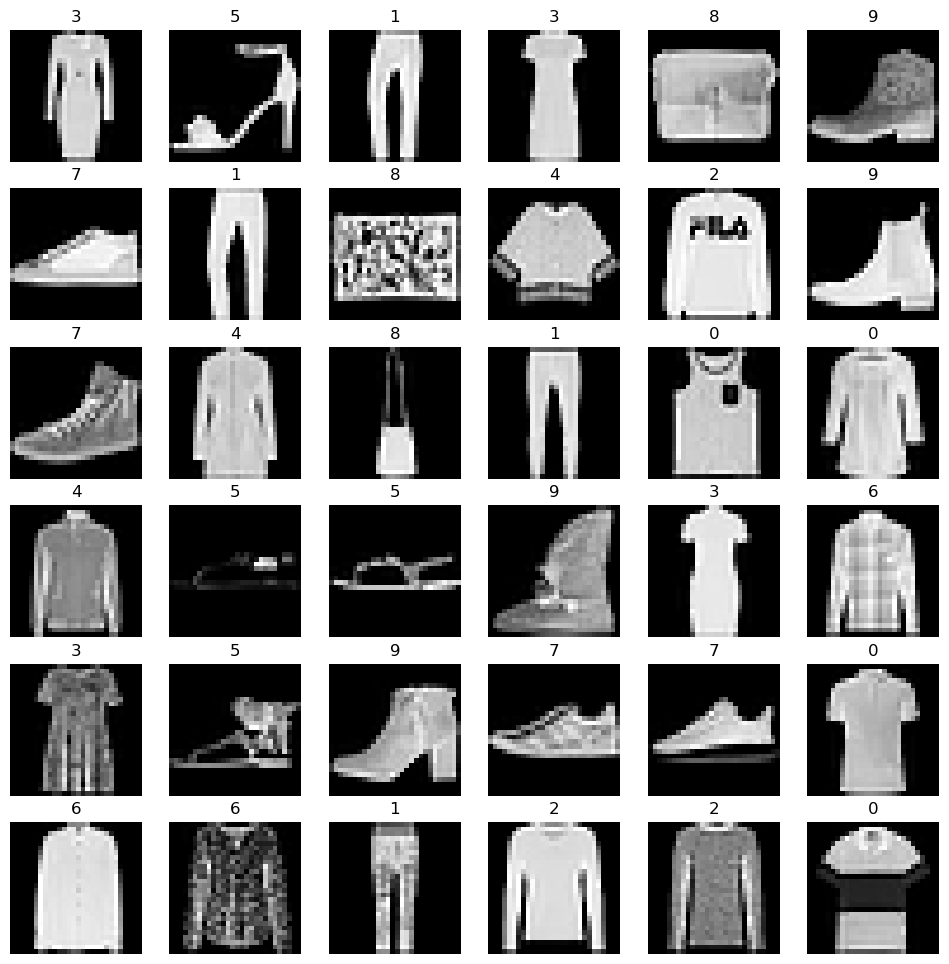

In [18]:

plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(36):
    ax1 = plt.subplot(6,6,i+1)
    images , labels = train_set[i]
    plt.imshow(images.reshape(28,28).detach().numpy(),cmap='gray')
    plt.title(labels)
    plt.axis('off')
plt.show()

## Create a lenet model

In [19]:

class lenet(nn.Module):
    def __init__(self):
        super(lenet,self).__init__()
        #convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        #ully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.flatten(out)  # Flatten the tensor
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        
        return out
my_resnet = lenet()

## implementing cross entropy loss function and adam optimizer

In [20]:
net = lenet().to('cpu')           # Creating object for LeNet() model and passing it to CPU  
loss_fn = nn.CrossEntropyLoss()   #loss funtion
opt = optim.Adam(net.parameters(),lr=0.001, weight_decay=0.0001) #optimizer for updating the model
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.01, patience=3) #sheduler to prevent overfitting 


In [21]:
#summary of the model
net.eval()

lenet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## function to find the accuracy of train set and val set

In [22]:
# to find accracy of the model
def evaluation(DataLoader):
    total , correct = 0,0
    for data in DataLoader:
        inputs , labels = data
        inputs = inputs.to('cpu') 
        labels = labels.to('cpu')
        output = net(inputs)            
        max_pred,pred = torch.max(output.data,dim=1)
        total +=labels.size(0)
        correct = correct + ((pred == labels).sum().item())  
    return 100 * correct / total 

## training and validating the model with 25 epochs 

In [23]:
loss_arr = []
loss_epoch_arr = []
val_loss_arr = []
acc_arr=[]
val_acc_arr=[]
def fit(max_epochs):
    batches = len(traindlr)
    val_batches = len(valdlr)
    for epoch in range(max_epochs):
        total_loss= 0 
        net.train()
        
        #training pahase
        for i, data in enumerate(traindlr):                          # Iterating through the train loader 
            inputs,labels = data
            inputs,labels = inputs.to('cpu'),labels.to('cpu')

    
            opt.zero_grad()                                          # Reset the gradient in every iteration
            outputs = net(inputs)
            loss = loss_fn(outputs,labels)                           # Loss forward pass
            loss.backward()                                          # Loss backaed pass
            
            opt.step()                                               # Update all the parameters by the given learnig rule
            total_loss += loss.item()
        loss_arr.append(total_loss)
        val_loss=0
        
        #validation phase
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(valdlr):                         # Iterating through the val loader 
                inputs,labels = data
                inputs,labels = inputs.to('cpu'),labels.to('cpu')

                outputs = net(inputs)
                val_loss += loss_fn(outputs,labels).item()            # Loss forward pass
        val_loss_arr.append(val_loss)                                 # to store validation loss
        scheduler.step(evaluation(valdlr))                            # to update 
        
        
        print('Val accuracy: %0.2f , Train accuracy : %0.2f'%(evaluation(valdlr),evaluation(traindlr)))#prints accuracy training and validation phase
        acc_arr.append(evaluation(traindlr))
        val_acc_arr.append(evaluation(valdlr))
        print('Val loss:'+ str(val_loss/val_batches) +' Train loss'+ str(total_loss/batches))
        
max_epochs = 25



fit(max_epochs)
torch.save(net, 'lenet.pt') 

Val accuracy: 86.72 , Train accuracy : 87.28
Val loss:0.37766335829149317 Train loss0.4734733292590017
Val accuracy: 89.82 , Train accuracy : 90.38
Val loss:0.2823002676043329 Train loss0.3057302995334806
Val accuracy: 90.85 , Train accuracy : 91.62
Val loss:0.2498799839728995 Train loss0.2578205635671116
Val accuracy: 90.43 , Train accuracy : 91.78
Val loss:0.25472444748576684 Train loss0.2252776198413061
Val accuracy: 91.97 , Train accuracy : 93.42
Val loss:0.2245234406635731 Train loss0.20460176959519497
Val accuracy: 92.10 , Train accuracy : 94.16
Val loss:0.2193269326905661 Train loss0.18548301590220703
Val accuracy: 92.36 , Train accuracy : 95.02
Val loss:0.21150012521804135 Train loss0.16678987872188963
Val accuracy: 92.17 , Train accuracy : 95.30
Val loss:0.22060387911675852 Train loss0.14810649217928157
Val accuracy: 92.65 , Train accuracy : 96.12
Val loss:0.21015516168709042 Train loss0.1366911707231608
Val accuracy: 92.41 , Train accuracy : 96.43
Val loss:0.22470981542822682

## using Open Vino to optimize the code 

In [25]:
#importing the required tools
from openvino.tools import mo
import cv2
import numpy as np
from openvino.runtime import Core, serialize
from openvino.inference_engine import IECore
dummy_input = torch.randn(64, 1, 28, 28)

# Export the model to ONNX 
output_path = "your_model.onnx"
torch.onnx.export(net, dummy_input, output_path, verbose=True)

print("Model successfully exported to ONNX format.")
ov_model = mo.convert_model('your_model.onnx')

# Convert ONNX model to OpenVINO IR using the Model Optimizer
output_dir = "openvino_model" 
serialize(ov_model, 'lenet_onnx_output/lenet_dynamic.xml')
core = Core()

# Load OpenVINO model on device
compiled_model = core.compile_model(ov_model)
compiled_model


ie = IECore()
model_xml = 'lenet_onnx_output/lenet_dynamic.xml'
model_bin = 'lenet_onnx_output/lenet_dynamic.bin'



Exported graph: graph(%input.1 : Float(64, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(128, 3136, strides=[3136, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/Conv_output_0 : Float(64, 32, 28, 28, strides=[25088, 784, 28, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="/conv1/Conv"](%input.1, %con

## check the inference of open vino model

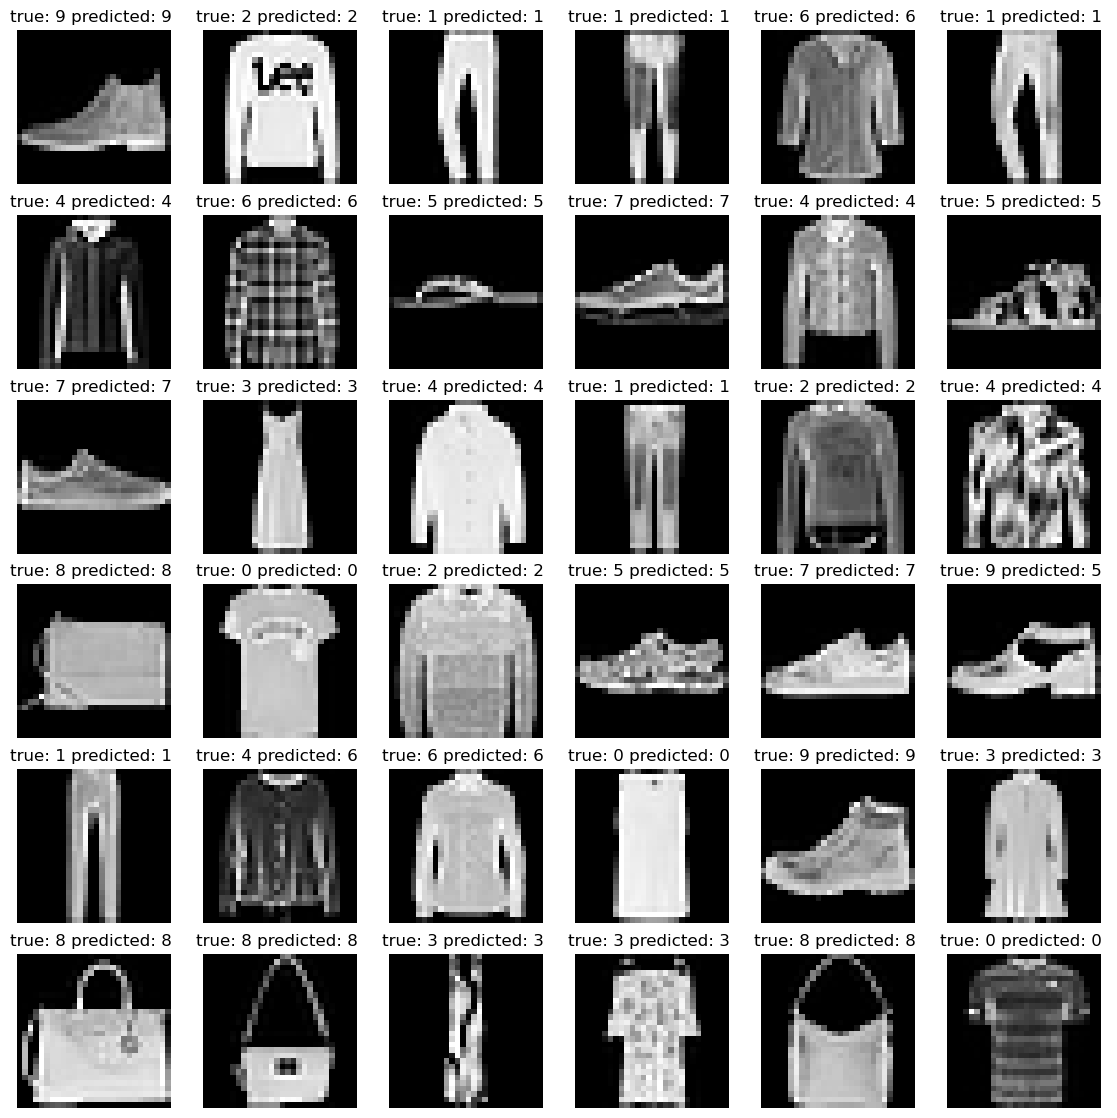

total   : 10000
correct : 9257
accuracy: 92.57 %


In [26]:

net1 = ie.read_network('lenet_onnx_output/lenet_dynamic.xml', 'lenet_onnx_output/lenet_dynamic.bin')

# Load the input and output blobs
input_blob = next(iter(net1.input_info))
output_blob = next(iter(net1.outputs))

prediction_list=[]

#for predicting all the images in testset using openvino model
total=0
correct = 0
label_list=[]
exec_net = ie.load_network(network=net1, device_name='CPU')
for i in range(len(testset)):
    images , labels = testset[i]
    total = len(testset)
    input_data = {input_blob: images}
    res = exec_net.infer(inputs=input_data)
    output_data = res[output_blob]
    predicted_class = np.argmax(output_data)
    correct = correct +((predicted_class == labels).sum().item())
    prediction_list.append(predicted_class)
    label_list.append(labels)

#plotting the first 36 images along with its acutal labels and predicted labels
plt.figure(figsize=(14,14))
plt.subplot(321)
for i in range(36) :
    ax1 = plt.subplot(6,6,i+1)
    images , labels = testset[i]

    plt.imshow(images.reshape(28,28).detach().numpy(),cmap='gray')

    ax1.set_title("true: {} predicted: {} " .format(str(labels), str(prediction_list[i])))
    plt.axis('off')
plt.show()

#printing the total values, correct, and accuracy
print("total   :",total)
print("correct :", correct)
print('accuracy:',correct*100/total,'%' )


## calculating the inference latency of the normal model vs open vino model

   ###     method 1

before optimization:  7.725276947021484 ms/image
after optimization:  1.333761215209961 ms/image


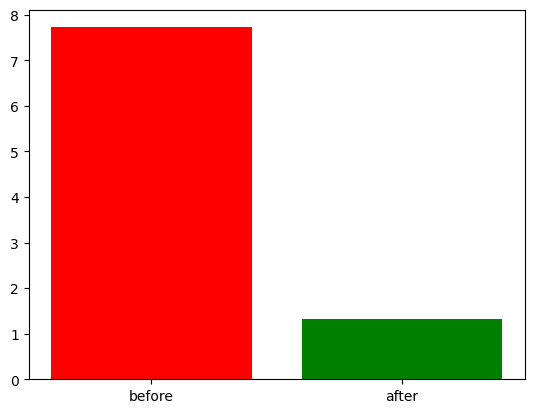

In [27]:
import time
for i, data in enumerate(traindlr): # Iterating through the train loader 
    inputs1,labels = data
    inputs1,labels = inputs1.to('cpu'),labels.to('cpu')
def measure_latency(input1):

    with torch.no_grad():
        for i in range(25):
            net(inputs1)
        start_time = time.time()
        for i in range(25):
            net(inputs1)
        end_time = time.time()
    n = 1000*(end_time - start_time)/25
    print('before optimization: ' ,n , 'ms/image')

    with torch.no_grad():
        for i in range(25):
            inputs2,labels = train_set[i]
            input_data = {input_blob: inputs2}

            output_ov = exec_net.infer(inputs=input_data)
        start_time = time.time()
        for i in range(25):
            inputs2,labels = train_set[i]
            input_data = {input_blob: inputs2}

            output_ov = exec_net.infer(inputs=input_data)
        end_time = time.time()

    n1 = 1000*(end_time - start_time)/25
    print('after optimization: ' ,n1, 'ms/image' )
    plt.bar(['before','after'], [n,n1],color=['r','g'])
measure_latency(inputs1)



### method 2

In [28]:
%%timeit
net(inputs1)


8.17 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
exec_net.infer(inputs=input_data)


1.03 ms ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## plotting

In [30]:
import matplotlib.pyplot
a=[]
b=1
for i in range (1,max_epochs+1):
    a.append(b)
    b += 1
    

### plotting for train-loss, validation-loss vs no-of-epochs

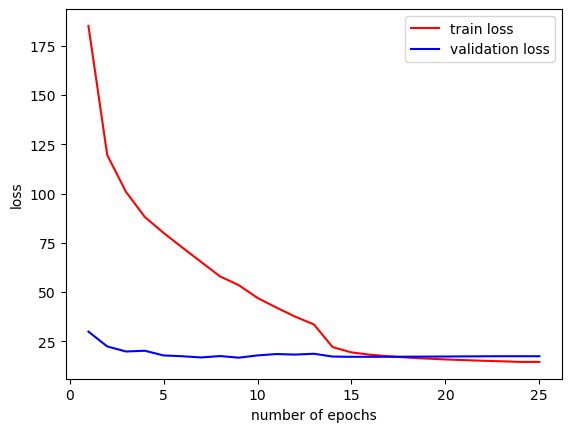

In [31]:
plt.plot(a,loss_arr,c='r',label='train loss')
plt.plot(a,val_loss_arr,c='b',label='validation loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend()

### plotting for train-accuracy, validation-accuracy vs no-of-epochs

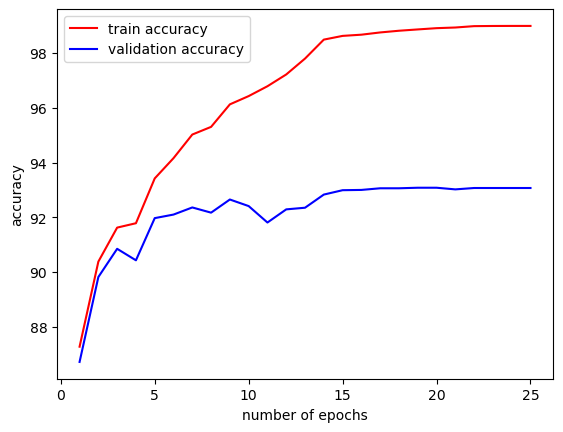

In [32]:
plt.plot(a,acc_arr,c='r',label = 'train accuracy')
plt.plot(a,val_acc_arr,c='b',label = 'validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of epochs')
plt.legend()

## displaying the confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(label_list,prediction_list))

[[875   0  11   8   3   2  93   0   7   1]
 [  3 984   0   7   2   0   2   0   2   0]
 [ 14   1 884   7  44   0  49   0   1   0]
 [ 14   4  10 930  21   0  20   0   1   0]
 [  0   0  50  22 879   0  47   0   2   0]
 [  0   0   0   0   0 990   0   6   0   4]
 [ 85   1  52  18  55   0 783   0   6   0]
 [  0   0   0   0   0   3   0 982   0  15]
 [  5   0   1   5   2   1   1   2 983   0]
 [  0   0   1   0   0   5   0  26   1 967]]


## visualizing the confusion matrix using sns.heatmap

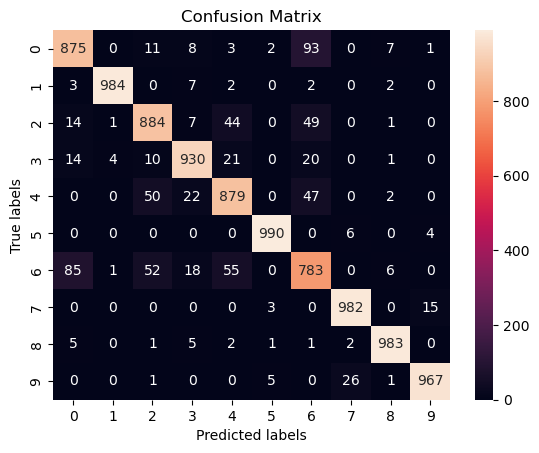

In [34]:
import seaborn as sns
ax=plt.subplot()
sns.heatmap(confusion_matrix(label_list,prediction_list),annot=True,fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9]); ax.yaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9]);